<a href="https://colab.research.google.com/github/diegoramfin/PCA-Based-Portfolio-Risk-Decomposition/blob/main/Portfolio_Risk_Decomposition_Using_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA-Based Portfolio Risk Decomposition

This notebook demonstrates how to apply **Principal Component Analysis (PCA)** to portfolio risk modeling in a way that mirrors production practices at quantitative investment firms.  

Key steps include:
- Downloading and cleaning market data from Yahoo Finance.  
- Estimating a **robust covariance matrix** using Ledoit–Wolf shrinkage.  
- Performing **eigen decomposition** of the covariance matrix to extract principal components.  
- Calculating **explained variance ratios**, **factor loadings**, and **factor returns**.  
- Decomposing total portfolio variance into contributions from each principal component.  
- Running a **rolling PCA** to observe how dominant risk factors evolve over time.  
- Constructing a **low-rank covariance approximation** based on top-k components for risk management.  

This workflow provides both a teaching example of PCA in risk analysis and a framework that can be extended toward production-level risk modeling.


In [ ]:
!pip install yfinance

In [ ]:
# Intial Market Data Grab

import yfinance as yf
import pandas as pd
import numpy as np

tickers = ['AAPL','MSFT','GOOGL','AMZN','TSLA','JPM','JNJ','XOM','PG','NVDA']
data = yf.download(tickers, start='2022-01-01', end='2025-01-01', auto_adjust=False)['Adj Close']
prices = data.dropna(how='all')
returns = np.log(prices / prices.shift(1)).dropna()
valid_assets = returns.columns[returns.isnull().mean() < 0.5]
returns = returns[valid_assets].dropna()
returns.head()

[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,MSFT,NVDA,PG,TSLA,XOM
Date,,,,,,,,,,
2022-01-04,-0.012773,-0.017060,-0.004091,-0.002685,0.037209,-0.017296,-0.027976,0.003493,-0.042733,0.036924
2022-01-05,-0.026960,-0.019074,-0.046962,0.006641,-0.018451,-0.039144,-0.059286,0.004516,-0.054954,0.012361
2022-01-06,-0.016834,-0.006734,-0.000199,-0.003432,0.010568,-0.007933,0.020581,-0.008439,-0.021758,0.023248
2022-01-07,0.000988,-0.004297,-0.005317,0.013427,0.009860,0.000510,-0.033598,-0.000553,-0.036090,0.008163
2022-01-10,0.000116,-0.006592,0.011989,-0.004956,0.000957,0.000732,0.005600,-0.013735,0.029891,-0.005970


In [ ]:
# Covariance Estimation

from sklearn.covariance import LedoitWolf

lw = LedoitWolf().fit(returns.values)
cov_matrix = lw.covariance_
cols = returns.columns
N = len(cols)

In [ ]:
#Eigen Decomposition

from pickle import load

import numpy.linalg as la

eigvals, eigvecs = la.eigh(cov_matrix)
eigvals = eigvals[::-1]
eigvecs = eigvecs[:, ::-1]

explained_var_ratio = eigvals / eigvals.sum()


factor_loadings = pd.DataFrame(
    eigvecs,
    index = returns.columns,
    columns=[f'PC{i+1}' for i in range (len(returns.columns))]
)

factor_loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Ticker,,,,,,,,,,
AAPL,-0.240328,-0.083572,0.210229,0.035579,-0.368462,0.241800,0.337463,-0.652738,0.392704,-0.037409
AMZN,-0.347557,-0.224376,0.436886,-0.280972,0.619974,-0.307232,0.209885,0.038174,0.180702,-0.046078
GOOGL,-0.281937,-0.217327,0.337550,-0.223027,-0.203752,0.420751,-0.643638,0.243848,0.124941,-0.041374
JNJ,-0.009321,-0.015276,0.194926,0.094696,-0.313718,-0.203567,0.192315,0.385307,0.255698,0.749686
JPM,-0.133331,-0.043468,0.215892,0.413719,-0.190372,-0.659093,-0.446567,-0.276251,-0.099654,-0.079041


In [ ]:
#Portfolio Variance & Risk Contribution

weights = np.full(N, 1/N)

#Portfolio Variance
port_var = float(weights.T @ cov_matrix @ weights)

# Absolute Factor Contributions
w_f = eigvecs.T @ weights
pc_risk_contrib = (w_f**2) * eigvals
pc_risk_contrib = pc_risk_contrib / pc_risk_contrib.sum() * port_var


# Transform weights into factor space: w_f = Q^T w, where Q = eigvecs
# Different Approach to Absolute Factor but done to show creativity of approaches

Q = eigvecs                           # (N, N)
w_f = Q.T @ weights                   # (N,)
factor_contrib = (w_f**2) * eigvals
factor_contrib_ratio = factor_contrib / factor_contrib.sum()


print(f"\nPortfolio variance: {port_var:.6e}")

print("Absolute Factor Contributions (Scaled in Proportion of Total Port Var):")
for i in range(len(pc_risk_contrib)):
    print(f"  PC{i+1}: {pc_risk_contrib[i]:.6e}")

print("Relative Factor Contribution ratios (% of Total Port Var):")
for i in range(len(factor_contrib_ratio)):
    print(f"  PC{i+1}: {factor_contrib_ratio[i]:.4f}")


Portfolio variance: 1.811814e-04
Absolute Factor Contributions (Scaled in Proportion of Total Port Var):
  PC1: 1.670704e-04
  PC2: 2.258702e-06
  PC3: 7.388748e-06
  PC4: 2.794806e-06
  PC5: 1.162008e-06
  PC6: 8.446777e-08
  PC7: 1.883549e-07
  PC8: 2.235626e-07
  PC9: 2.435340e-09
  PC10: 7.925364e-09
Relative Factor Contribution ratios (% of Total Port Var):
  PC1: 0.9221
  PC2: 0.0125
  PC3: 0.0408
  PC4: 0.0154
  PC5: 0.0064
  PC6: 0.0005
  PC7: 0.0010
  PC8: 0.0012
  PC9: 0.0000
  PC10: 0.0000


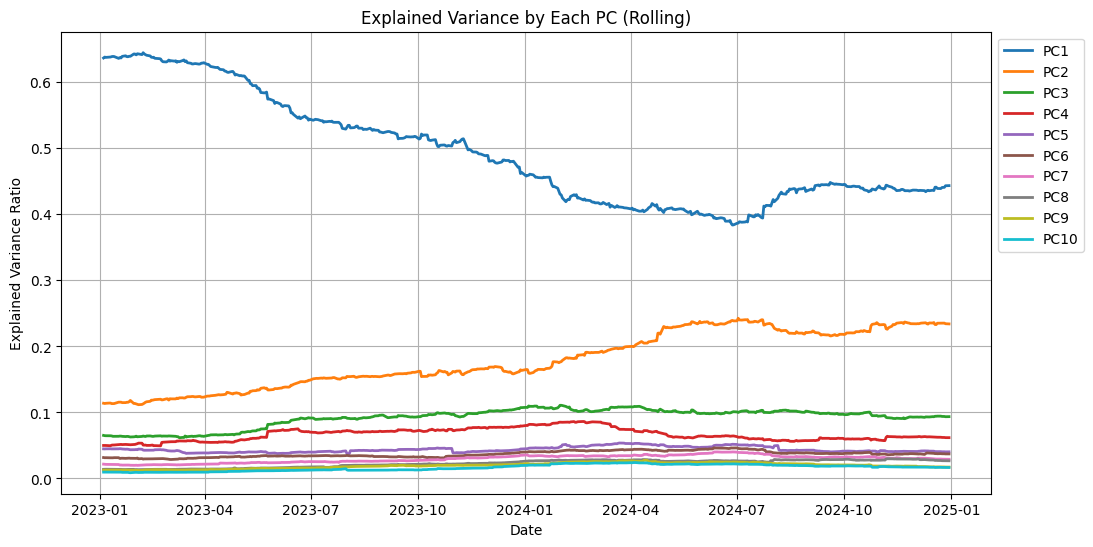

In [ ]:
# Rolling Eigen Decomposition on Ledoit–Wolf Covariance

import matplotlib.pyplot as plt
import numpy as np

window = 252
rolling_explained_var = []
rolling_idx = []

for end in range(window, len(returns)):
    sub = returns.iloc[end-window:end]
    # shrinkage covariance per window
    lw = LedoitWolf().fit(sub.values)
    C = lw.covariance_
    # eigen on C
    vals, vecs = la.eigh(C)
    vals = vals[::-1]
    # explained variance ratio for this window
    evr = vals / vals.sum()
    rolling_explained_var.append(evr)
    rolling_idx.append(sub.index[-1])

rolling_explained_var = pd.DataFrame(rolling_explained_var,
                                     index=pd.DatetimeIndex(rolling_idx),
                                     columns=[f'PC{i+1}' for i in range(len(returns.columns))])

plt.figure(figsize=(12,6))
for col in rolling_explained_var.columns:
    plt.plot(rolling_explained_var[col], label=col, linewidth=2)
plt.title("Explained Variance by Each PC (Rolling)")
plt.xlabel("Date")
plt.ylabel("Explained Variance Ratio")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [ ]:
# Factor Returns via Projection


R = returns.values                    # (T, N)
F = R @ eigvecs                       # (T, N) factor returns (PC1..PCN)
factor_returns = pd.DataFrame(F, index=returns.index, columns=[f"PC{i+1}" for i in range(N)])


F_scaled = pd.DataFrame(F / np.sqrt(eigvals),                 # not required for most reporting
                        index=returns.index,
                        columns=[f"PC{i+1}" for i in range(N)])

factor_returns.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Date,,,,,,,,,,
2022-01-04,0.048899,-0.014111,0.024222,0.047483,0.001233,-0.010611,-0.021955,-0.002529,-0.001516,-0.010473
2022-01-05,0.103301,0.009185,0.006039,0.012499,0.017409,-0.007410,0.019211,0.009573,0.012304,-0.001591
2022-01-06,0.008232,-0.022953,-0.013495,0.028580,0.013144,0.000379,-0.014235,0.007028,-0.001945,0.001262
2022-01-07,0.040876,-0.011720,0.027670,0.008400,-0.005733,-0.005755,0.001050,-0.005433,-0.001449,0.008979
2022-01-10,-0.021684,0.020594,-0.008827,-0.005522,-0.001142,0.007740,-0.015763,-0.004267,-0.002258,0.005162


In [ ]:
#Per-asset marginal contribution to risk (MCR) and component contribution (CCR)
# MCR_i = (Sigma w)_i / sqrt(w^T Sigma w); CCR_i = w_i * MCR_i * sqrt(w^T Sigma w)

Sigma_w = cov_matrix @ weights
mcr = Sigma_w / np.sqrt(port_var)             # marginal contribution to stdev
ccr = weights * mcr * np.sqrt(port_var)       # component contribution to stdev
mcr_df = pd.DataFrame({"MCR": mcr, "CCR": ccr}, index=cols).sort_values("CCR", ascending=False)
mcr_df.head()


,MCR,CCR
Ticker,,
TSLA,0.027242,0.000037
NVDA,0.026510,0.000036
AMZN,0.018743,0.000025
GOOGL,0.015638,0.000021
MSFT,0.013978,0.000019


In [ ]:
# Low-Rank Covariance Approximation

threshold = 0.75  # retain 75% of variance; tune to liking
cum = np.cumsum(explained_var_ratio)
k = int(np.searchsorted(cum, threshold) + 1)

# Low-rank covariance: Q_k diag(eigvals_k) Q_k^T

Qk = Q[:, :k]
Lk = np.diag(eigvals[:k])
cov_lowrank = Qk @ Lk @ Qk.T

print(f"Selected k={k} PCs covering {cum[k-1]:.1%} of total variance.")


Selected k=3 PCs covering 77.9% of total variance.


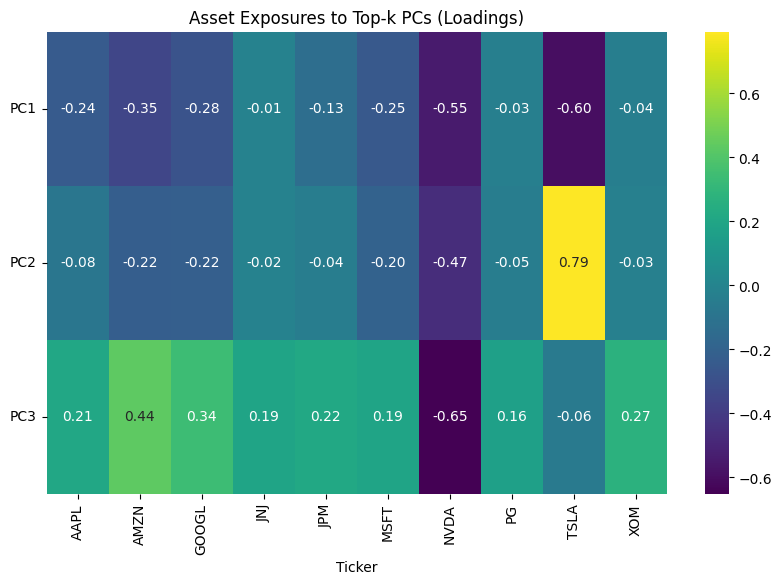

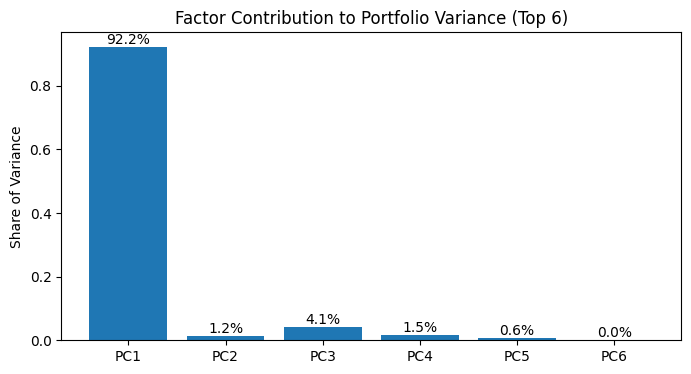

In [47]:
# --- Loadings Heatmap for top-k PCs ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

topk_load = pd.DataFrame(Qk, index=cols, columns=[f"PC{i+1}" for i in range(k)])
topk_load.sort_index(inplace=True)

plt.figure(figsize=(10, max(6, int(N*0.25))))
sns.heatmap(topk_load.T, cmap="viridis", annot=True, fmt=".2f") # Use seaborn.heatmap and transpose for better visualization
plt.yticks(rotation=0)
plt.xticks(rotation=90) # Rotate x-axis labels
plt.title("Asset Exposures to Top-k PCs (Loadings)")
plt.show()

# --- Factor contribution bar chart ---
plt.figure(figsize=(8,4))
bars = plt.bar([f"PC{i+1}" for i in range(6)], factor_contrib_ratio[:6])
plt.title("Factor Contribution to Portfolio Variance (Top 6)")
plt.ylabel("Share of Variance")

# Add percentages to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1%}', va='bottom', ha='center')

plt.show()